In [1]:
# standart libs
import sys
import random
import copy
from operator import itemgetter
from PIL import Image


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import scipy.stats as ss
from skimage import measure


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

# executable
print(sys.executable)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/home/stefan/coding/notebooks/env/bin/python


In [2]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)

Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [3]:
# meta
geo_model_extent_1 = [0,1000,0,1000,0,1000]
section_1 = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df_1 = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df_1.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df_1.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df_1 = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df_1.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df_1.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df_1.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

# geoData
surface_points_input_data_1 = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data_1 = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df_1 = surface_points_input_data_1[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df_1.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df_1['param1'] = 10

# Orientaions
orientations_original_df_1 = orientaions_input_data_1[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

In [4]:
# %%timeit
# setup model 1
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()


In [5]:
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

Run realizations setup checks until stable workflow.
HOTFIX in gempy/core/gempy_api.py 328


/home/stefan/coding/notebooks/env/lib/python3.8/site-packages/gempy/core/solution.py:196: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  vertices, simplices, normals, values = measure.marching_cubes_lewiner(


# Find contours of surfaces

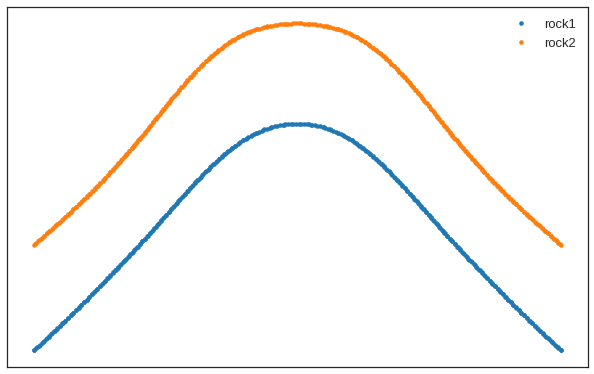

In [10]:
# get section contours
contours = post_pro.compute_section_contours(geo_model)

# for konva  # x0y0x1y1...xnyn
contours_konva = post_pro.process_section_contours_for_konva(contours)

# plot
fig, ax = plt.subplots()

for key in contours.keys():
    
    ax.plot(contours[key][:,0], contours[key][:,1], '.', label=key)
    
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.legend()
plt.show()

# Parametize a line

## Get and prepare a line for developement

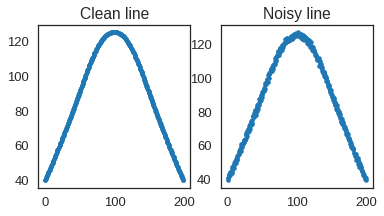

In [11]:
# load line
xs, ys = contours['rock1'][:,0], contours['rock1'][:,1]

# add noise
noise = np.random.normal(0,1,len(xs))
ys_noisy = ys + noise

# plot
fig, (ax_1, ax_2) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(6, 3))

ax_1.set_title('Clean line')
ax_1.plot(xs, ys, '.')

ax_2.set_title('Noisy line')
ax_2.plot(xs, ys_noisy, '.')

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Find minima and maxima

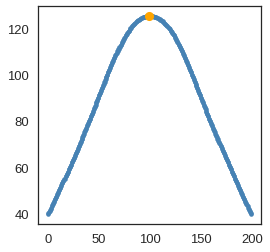

In [16]:

xs_extrems, ys_extrems = post_pro.get_line_extrema(xs, ys)

# plot
fig, (ax_1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(4, 4))
ax_1.plot(xs, ys, '.', color='steelblue')
ax_1.plot(xs_extrems, ys_extrems, 'o', color='orange')
plt.show()